# Anime Recommendator

The aim of this work is to build an anime recommendator exploring two main techniques: clustering and TF-IDF. Let's see how we can achieve that!!

[1.Data Overview](#DataOverview)


*   [1.1 Anime Dataset](#AnimeDataset)
*   [1.2 Best Anime TV Show](#bestAnimeTVShow)
*   [1.3 Worst Anime TV Show](#worstAnimeTVShow)
*   [1.4 Best Anime Movie](#bestAnimeMovie)
*   [1.5 Worst Anime Movie](#worstAnimeMovie)
*   [1.6 Longest Anime TV Show](#longestAnimeTVshow)
*   [1.7 Shortest Anime TV Show](#shortestAnimeTVshow)
*   [1.8 Most Popular Anime Genre](#mostPopularAnimeGenre)




In [1]:
import os
import numpy as np
import pandas as pd

import warnings

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Import some files
from google.colab import files
uploaded = files.upload()

Saving anime.csv to anime.csv


In [4]:
 #leer dataset con el que se va trabajar
import pandas as pd
anime_complete_df = pd.read_csv('anime.csv')

<a name="DataOverview"></a>
# 1. Data overview

<a name="AnimeDataset"></a>
*1.1 Anime Dataset* 

Lets took a quick overview of the structure of the data...

In [5]:
anime_complete_df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


<a name="bestAnimeTVShow"></a>
*1.2 Which is the best anime TV show??*

In [6]:
#First we are gonna filter the shows based on the categorie
tvShowMask = (anime_complete_df["type"]=="TV")
animeTVShowsDF = anime_complete_df[tvShowMask]

In [7]:
animeTVShowsDF.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


In this case the data seems to be sorted, but what if...?

In [8]:
#We are sorting the data based on the column 'rating'
animeTVShowsDF.sort_values('rating', ascending=False)

,anime_id,name,genre,type,episodes,rating,members
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
11104,34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,Unknown,NaN,381
11106,34467,Yami Shibai 4th Season,"Dementia, Horror, Supernatural",TV,Unknown,NaN,1838
11107,32615,Youjo Senki,"Magic, Military",TV,Unknown,NaN,6652
11110,34284,Yuuki Yuuna wa Yuusha de Aru: Washio Sumi no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,NaN,2593


The result is a bit extrange: Spoon-hime no swing kitchen!! -it sounds like a bad joke, isn't it? - But this result has a explanation: this show is not as popular as the other ones. So is not fair enough to take this answer as correct.

In [9]:
#storage number of members per anime
membersSoFar=[]
for i in range(len(animeTVShowsDF)):
  membersSoFar.append(animeTVShowsDF.iloc[i]['members'])

Once the ratings are available, a study of the percentiles can be made.

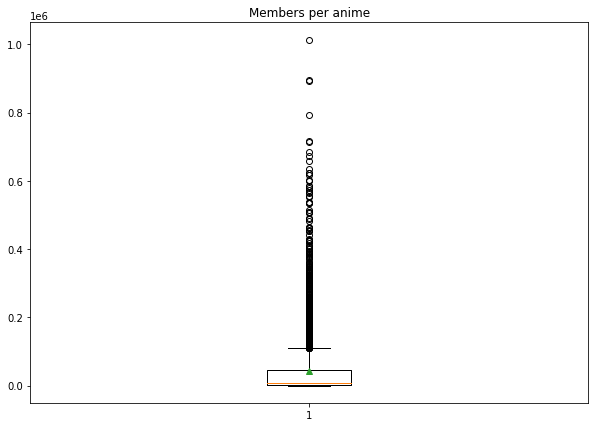

In [10]:
#BoxPlot
fig = plt.figure(figsize =(10, 7))
# Creating plot
bp = plt.boxplot(membersSoFar,showmeans=True) 
# show plot
plt.title("Members per anime")
plt.show()

In [11]:
medians = [round(item.get_ydata()[0], 1) for item in bp['medians']]
means = [round(item.get_ydata()[0], 1) for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

Medians: [5947.0]
Means:   [42683.7]


In [12]:
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
print(f'Q1: {q1}\n'
      f'Q3: {q3}')

Q1: [483.0]
Q3: [44246.0]


Once the value of q1 is obtained, we can iterate again over the data set and keep the animes whose number of members is greater than that.

In [13]:
animesWithMoreMembersThanQ1 = []
for i in range(len(animeTVShowsDF)):
  if(animeTVShowsDF.iloc[i]['members']>q1):
    #we have something like a mask with positions
    animesWithMoreMembersThanQ1.append(i)

In [14]:
animeTVShowsDF.iloc[animesWithMoreMembersThanQ1].sort_values('rating', ascending=False)

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
...,...,...,...,...,...,...,...
11102,32924,Urara Meirochou,"Comedy, Seinen, Slice of Life",TV,Unknown,NaN,4305
11106,34467,Yami Shibai 4th Season,"Dementia, Horror, Supernatural",TV,Unknown,NaN,1838
11107,32615,Youjo Senki,"Magic, Military",TV,Unknown,NaN,6652
11110,34284,Yuuki Yuuna wa Yuusha de Aru: Washio Sumi no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,NaN,2593


Now we can have a slightly clearer view. The best anime is **FMAB**!

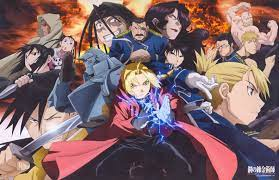

<a name="worstAnimeTVShow"></a>
*1.3 Which is the worst anime TV show??*

In [15]:
animeTVShowsDF.iloc[animesWithMoreMembersThanQ1].sort_values('rating', ascending=True).head()

,anime_id,name,genre,type,episodes,rating,members
8037,28929,Vampire Holmes,"Comedy, Mystery, Supernatural, Vampire",TV,12,3.63,10403
8024,19315,Pupa,"Fantasy, Horror, Psychological",TV,12,3.82,83652
8014,33394,Mahou Shoujo? Naria☆Girls,Magic,TV,12,3.91,3414
7984,1812,Hanoka,Sci-Fi,TV,12,4.27,1686
7964,33021,Ragnastrike Angels,Action,TV,12,4.42,7365


The worst anime given the dataset is **Vampire Holmes**

<a name="bestAnimeMovie"></a>
*1.4 Which is the best anime movie??*

In [16]:
#First we are gonna filter the shows based on the categorie
movieShowMask = anime_complete_df["type"]=="Movie"
animeMovieShowsDF = anime_complete_df[movieShowMask]

In [17]:
animeMovieShowsDF.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193


In [18]:
animeMovieShowsDF.sort_values('rating', ascending=False)

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
...,...,...,...,...,...,...,...
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,1,NaN,19813
11098,34498,"Uchiage Hanabi, Shita kara Miru ka? Yoko kara ...",Drama,Movie,1,NaN,531
11108,32222,Youkai Watch Movie 3: Soratobu Kujira to Doubl...,"Comedy, Kids, Supernatural",Movie,1,NaN,237
11109,34471,Youkai Watch Movie 4,"Comedy, Kids, Supernatural",Movie,1,NaN,169


Now, we follow the same approach of the previous thing. The exact same thing is happening again !!

In [19]:
membersSoFar=[]
for i in range(len(animeMovieShowsDF)):
  membersSoFar.append(animeMovieShowsDF.iloc[i]['members'])

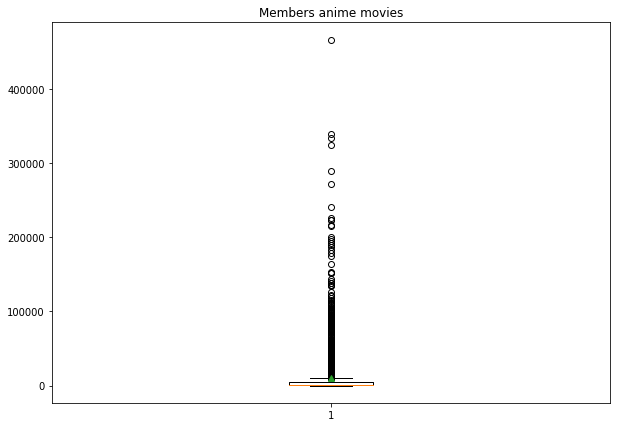

In [20]:
#BoxPlot
fig = plt.figure(figsize =(10, 7))
# Creating plot
bp = plt.boxplot(membersSoFar,showmeans=True) 
# show plot
plt.title("Members anime movies")
plt.show()

In [21]:
medians = [round(item.get_ydata()[0], 1) for item in bp['medians']]
means = [round(item.get_ydata()[0], 1) for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

Medians: [499.5]
Means:   [10360.3]


In [22]:
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
print(f'Q1: {q1}\n'
      f'Q3: {q3}')

Q1: [120.0]
Q3: [4189.2]


In [23]:
animesMoviesWithMoreMembersThanQ1 = []
for i in range(len(animeMovieShowsDF)):
  if(animeMovieShowsDF.iloc[i]['members']>q1):
    #we create something like a simple mask with the positions of interest
    animesMoviesWithMoreMembersThanQ1.append(i)

In [24]:
animeMovieShowsDF.iloc[animesMoviesWithMoreMembersThanQ1].sort_values('rating', ascending=False)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193
...,...,...,...,...,...,...,...
11094,33581,Trinity Seven Movie: Eternity Library to Alche...,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",Movie,1,NaN,19813
11098,34498,"Uchiage Hanabi, Shita kara Miru ka? Yoko kara ...",Drama,Movie,1,NaN,531
11108,32222,Youkai Watch Movie 3: Soratobu Kujira to Doubl...,"Comedy, Kids, Supernatural",Movie,1,NaN,237
11109,34471,Youkai Watch Movie 4,"Comedy, Kids, Supernatural",Movie,1,NaN,169


Then, the best movie is **Kimi no na wa** ^^ . This result is pretty normal, right?

<a name="worstAnimeMovie"></a>
*1.5 Which is the worst anime movie?*

In [25]:
animeMovieShowsDF.iloc[animesMoviesWithMoreMembersThanQ1].sort_values('rating', ascending=True).head()

,anime_id,name,genre,type,episodes,rating,members
12258,20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129
10087,14781,Roboteuwang Sseonsyakeu,"Action, Mecha, Sci-Fi",Movie,1,2.49,121
8055,29949,Nami,Dementia,Movie,1,2.67,1817
8053,6953,Ningen Doubutsuen,Dementia,Movie,1,2.78,1893
8277,16786,Bulsajo Robot Phoenix King,"Action, Mecha, Shounen, Space",Movie,1,3.11,133


The worst movie given the dataset is **Hi Gekiga Ukiyoe Senya Ichiya**

<a name="longestAnimeTVshow"></a>
*1.6 Which is the longest anime TV show??*


In [26]:
animeTVShowsDF.sort_values('episodes', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
9119,32568,Kamiwaza Wanda,"Kids, Sci-Fi",TV,Unknown,5.29,316
9549,32402,Mim Mam Mint,Comedy,TV,Unknown,4.10,228
9792,24403,Nyanpuku Nyaruma,Comedy,TV,Unknown,4.00,176
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
9790,24845,Nyanfuru,"Comedy, Music",TV,Unknown,5.54,159


We have a little problem. Some rows -animes- are asocciated to the value 'Unknown'. We can make a little filter then.

In [27]:
positionsNumberOfEpisodesNumerics=[]
for i in range(len(animeTVShowsDF)):
  if(animeTVShowsDF.iloc[i].episodes.isnumeric()==True):
    positionsNumberOfEpisodesNumerics.append(i)

In [28]:
#remember that with the use of iloc we could explore certain index -like pure index or list of index-
animeTVShowsDF.iloc[positionsNumberOfEpisodesNumerics].sort_values('episodes', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
2276,3437,Mister Ajikko,"Comedy, Shounen",TV,99,7.31,1828
69,12431,Uchuu Kyoudai,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",TV,99,8.59,72958
1128,2268,Tatakae! Chou Robot Seimeitai Transformers,"Adventure, Mecha, Sci-Fi, Shounen",TV,98,7.67,5652
588,6033,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,97,7.95,116832
3446,2707,Majime ni Fumajime Kaiketsu Zorori,"Adventure, Kids",TV,97,6.99,390


<a name="shortestAnimeTVshow"></a>
*1.7 Which is the shortest anime TV show??*


In [29]:
positionsNumberOfEpisodesNumericsShortest=[]
for i in range(len(animeTVShowsDF)):
  if(animeTVShowsDF.iloc[i].episodes.isnumeric()==True and animeTVShowsDF.iloc[i].episodes.isnumeric()>0):
    positionsNumberOfEpisodesNumericsShortest.append(i)

In [30]:
animeTVShowsDF.iloc[positionsNumberOfEpisodesNumerics].sort_values('episodes', ascending=True).head()

,anime_id,name,genre,type,episodes,rating,members
9293,29738,Konchuu Monogatari Tentoumu Chu! to Mitsubachi...,Music,TV,10,5.47,75
1429,19221,"Ore no Nounai Sentakushi ga, Gakuen Love Comed...","Comedy, Romance, School",TV,10,7.55,179569
6389,22381,Nandaka Velonica,"Comedy, Fantasy, Kids",TV,10,6.14,737
6313,10908,Kakko Kawaii Sengen! 2,Comedy,TV,10,6.17,324
6312,25429,Isuca,"Action, Comedy, Ecchi, Romance, School, Seinen...",TV,10,6.17,63638


<a name="mostPopularAnimeGenre"></a>
*1.8 Which is the most popular anime genre?*

In [46]:
from collections import Counter

In [47]:
#First approach: make traversal through genres
#Second approach: create a dictionary with all the genres
aux = []
genresStorageBag = []
for i in range(len(animeTVShowsDF)):
  #not take nan values in consideration
  aux = animeTVShowsDF.iloc[i].genre
  #this check is necessary because there are also 'nan' types elements
  if (isinstance(aux, str)):
    aux = aux.split(",")
    for g in aux:
      genresStorageBag.append(g)
#Now, we simply create a counter
genres = Counter(genresStorageBag)

Because the horizontal axis is really width, we should do click on the picture to get the full information!!

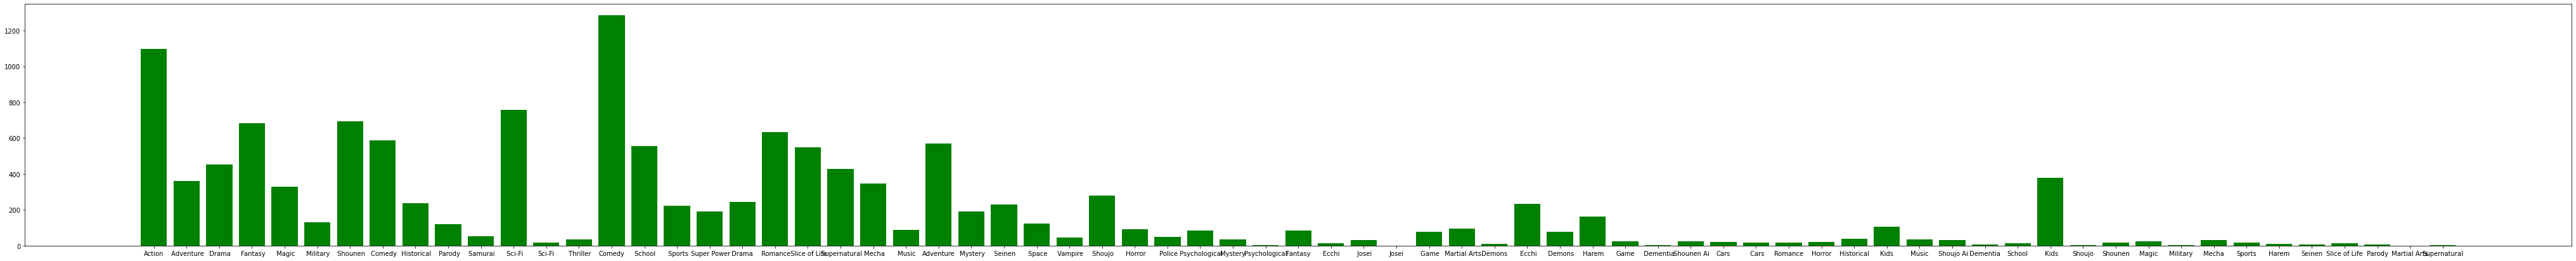

In [64]:
fig = plt.figure(figsize =(72, 7))
plt.bar(genres.keys(), genres.values(),color="green")
plt.show()

After analysing all the genres of the given anime, it can be stated that the most popular genre is comedy.